In [1]:
# !pip install kagglehub
# !pip install pandas numpy scikit_learn
# !pip install seaborn
# !pip install hdbscan

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.cluster import HDBSCAN
from sklearn.preprocessing import StandardScaler

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")

print("Path to dataset files:", path)

C:\Users\ASUS\Desktop\git pro\PythonProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\ASUS\.cache\kagglehub\datasets\elemento\nyc-yellow-taxi-trip-data\versions\2


In [4]:
files = os.listdir(path)
print("Files in dataset:", files)

Files in dataset: ['yellow_tripdata_2015-01.csv', 'yellow_tripdata_2016-01.csv', 'yellow_tripdata_2016-02.csv', 'yellow_tripdata_2016-03.csv']


In [5]:
df = pd.read_csv(os.path.join(path, 'yellow_tripdata_2016-03.csv'))

In [6]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,2.50,-73.976746,40.765152,1,N,-74.004265,40.746128,1,9.0,0.5,0.5,2.05,0.00,0.3,12.35
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,2.90,-73.983482,40.767925,1,N,-74.005943,40.733166,1,11.0,0.5,0.5,3.05,0.00,0.3,15.35
2,2,2016-03-01 00:00:00,2016-03-01 00:31:06,2,19.98,-73.782021,40.644810,1,N,-73.974541,40.675770,1,54.5,0.5,0.5,8.00,0.00,0.3,63.80
3,2,2016-03-01 00:00:00,2016-03-01 00:00:00,3,10.78,-73.863419,40.769814,1,N,-73.969650,40.757767,1,31.5,0.0,0.5,3.78,5.54,0.3,41.62
4,2,2016-03-01 00:00:00,2016-03-01 00:00:00,5,30.43,-73.971741,40.792183,3,N,-74.177170,40.695053,1,98.0,0.0,0.0,0.00,15.50,0.3,113.80


In [7]:
df.shape

(12210952, 19)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12210952 entries, 0 to 12210951
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   pickup_longitude       float64
 6   pickup_latitude        float64
 7   RatecodeID             int64  
 8   store_and_fwd_flag     object 
 9   dropoff_longitude      float64
 10  dropoff_latitude       float64
 11  payment_type           int64  
 12  fare_amount            float64
 13  extra                  float64
 14  mta_tax                float64
 15  tip_amount             float64
 16  tolls_amount           float64
 17  improvement_surcharge  float64
 18  total_amount           float64
dtypes: float64(12), int64(4), object(3)
memory usage: 1.7+ GB


In [9]:
def dataset_info(df):
    print("Shape:  ", df.shape)
    print("Columns:  ", df.columns)
    print()
    print("Missing Values: ", df.isna().sum().sum())
    print("Duplicate: ", df.duplicated().sum())

dataset_info(df)

Shape:   (12210952, 19)
Columns:   Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

Missing Values:  0
Duplicate:  1


In [10]:
df[df.duplicated()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
12210947,1,2016-03-31 16:34:36,2016-03-31 16:34:36,1,0.0,0.0,0.0,1,Y,0.0,0.0,2,19.0,1.0,0.5,0.0,0.0,0.3,20.8


## Preprocessing

In [11]:
df = df.drop_duplicates(keep=False)

In [12]:
cols = ["VendorID", 'payment_type', 'fare_amount','extra', 'mta_tax', 'tip_amount', 'tolls_amount','improvement_surcharge', 'total_amount',
        "passenger_count", "RatecodeID", "store_and_fwd_flag"]
df.drop(columns= cols, inplace= True, errors="ignore")

In [13]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2016-03-01 00:00:00,2016-03-01 00:07:55,2.50,-73.976746,40.765152,-74.004265,40.746128
1,2016-03-01 00:00:00,2016-03-01 00:11:06,2.90,-73.983482,40.767925,-74.005943,40.733166
2,2016-03-01 00:00:00,2016-03-01 00:31:06,19.98,-73.782021,40.644810,-73.974541,40.675770
3,2016-03-01 00:00:00,2016-03-01 00:00:00,10.78,-73.863419,40.769814,-73.969650,40.757767
4,2016-03-01 00:00:00,2016-03-01 00:00:00,30.43,-73.971741,40.792183,-74.177170,40.695053


In [14]:
df.rename(columns={
    "pickup_longitude": "start_lon",
    "pickup_latitude": "start_lat",
    "dropoff_longitude": "end_lon",
    "dropoff_latitude": "end_lat"
}, inplace=True)

In [15]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,start_lon,start_lat,end_lon,end_lat
0,2016-03-01 00:00:00,2016-03-01 00:07:55,2.50,-73.976746,40.765152,-74.004265,40.746128
1,2016-03-01 00:00:00,2016-03-01 00:11:06,2.90,-73.983482,40.767925,-74.005943,40.733166
2,2016-03-01 00:00:00,2016-03-01 00:31:06,19.98,-73.782021,40.644810,-73.974541,40.675770
3,2016-03-01 00:00:00,2016-03-01 00:00:00,10.78,-73.863419,40.769814,-73.969650,40.757767
4,2016-03-01 00:00:00,2016-03-01 00:00:00,30.43,-73.971741,40.792183,-74.177170,40.695053


In [16]:
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

In [17]:
df['pickup_hour'] = df["tpep_pickup_datetime"].dt.hour
df['pickup_day'] = df["tpep_pickup_datetime"].dt.day
# df['pickup_month'] = df["tpep_pickup_datetime"].dt.month
df['pickup_dayofweek'] = df["tpep_pickup_datetime"].dt.dayofweek

In [18]:
df["dropoff_hour"] = df["tpep_dropoff_datetime"].dt.hour
df["dropoff_day"] = df["tpep_dropoff_datetime"].dt.day
# df["dropoff_month"] = df["tpep_dropoff_datetime"].dt.month
df['dropoff_dayofweek'] = df["tpep_dropoff_datetime"].dt.dayofweek

In [19]:
# df["pickup_month"].unique()

In [20]:
df["dropoff_hour"].unique()

array([ 0,  7,  8,  6,  9, 15, 10, 12, 11, 18, 13, 14, 23,  1,  2,  3,  4,
        5, 20, 16, 17, 19, 21, 22], dtype=int32)

In [21]:
df["dropoff_dayofweek"].unique()

array([1, 3, 4, 2, 5, 6, 0], dtype=int32)

In [22]:
df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance',
       'start_lon', 'start_lat', 'end_lon', 'end_lat', 'pickup_hour',
       'pickup_day', 'pickup_dayofweek', 'dropoff_hour', 'dropoff_day',
       'dropoff_dayofweek'],
      dtype='object')

In [23]:
df = df[df['start_lon'].between(-74.26, -73.7)]
df = df[df['end_lon'].between(-74.26, -73.7)]
df = df[df['start_lat'].between(40.49, 40.92)]
df = df[df['end_lat'].between(40.49, 40.92)]

In [24]:
hourly_trips = df.groupby("pickup_hour").size()
weekday_trips = df.groupby("pickup_dayofweek").size()
# monthly_trips = df.groupby("pickup_month").size()

Text(0, 0.5, 'Trips Count')

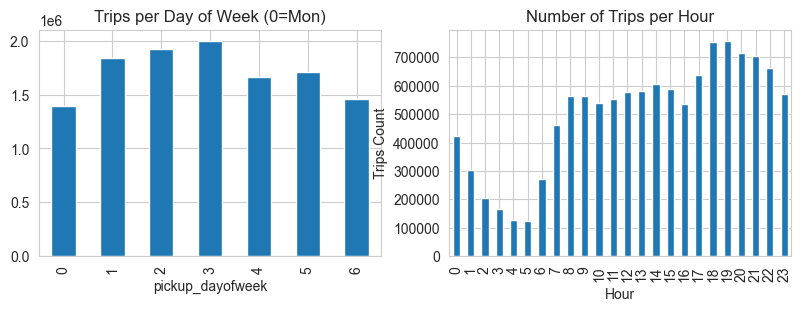

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
weekday_trips.plot(kind="bar")
plt.title("Trips per Day of Week (0=Mon)")

plt.subplot(3,3,2)
hourly_trips.plot(kind="bar")
plt.title("Number of Trips per Hour")
plt.xlabel("Hour")
plt.ylabel("Trips Count")
#
# plt.subplot(3,3,3)
# monthly_trips.plot(kind="bar")
# plt.title("Trips per Month")
# plt.xlabel("Month")
# plt.ylabel("Trips Count")
# plt.show()

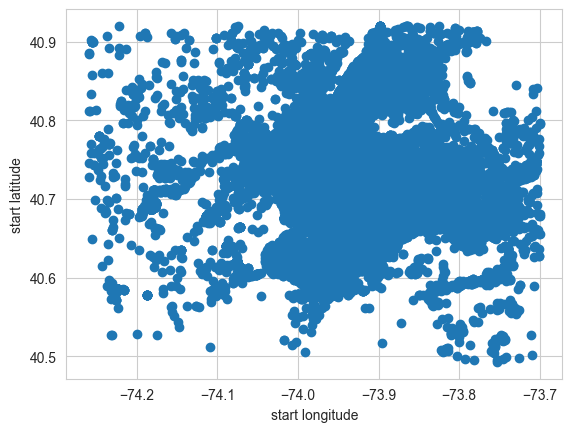

In [26]:
plt.scatter(df["start_lon"], df["start_lat"])
plt.xlabel("start longitude")
plt.ylabel("start latitude")
plt.show()

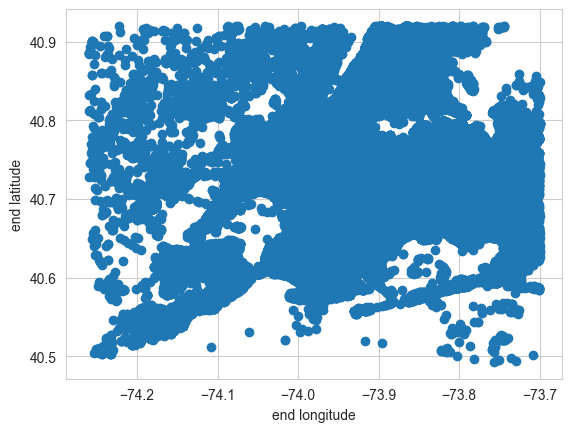

In [27]:
plt.scatter(df["end_lon"], df["end_lat"])
plt.xlabel("end longitude")
plt.ylabel("end latitude")
plt.show()

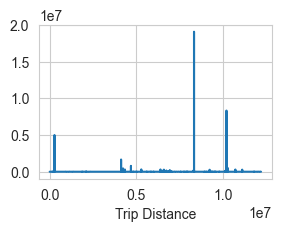

In [28]:
plt.figure(figsize=(3,2))
plt.plot(df["trip_distance"])
plt.xlabel("Trip Distance")
plt.show()

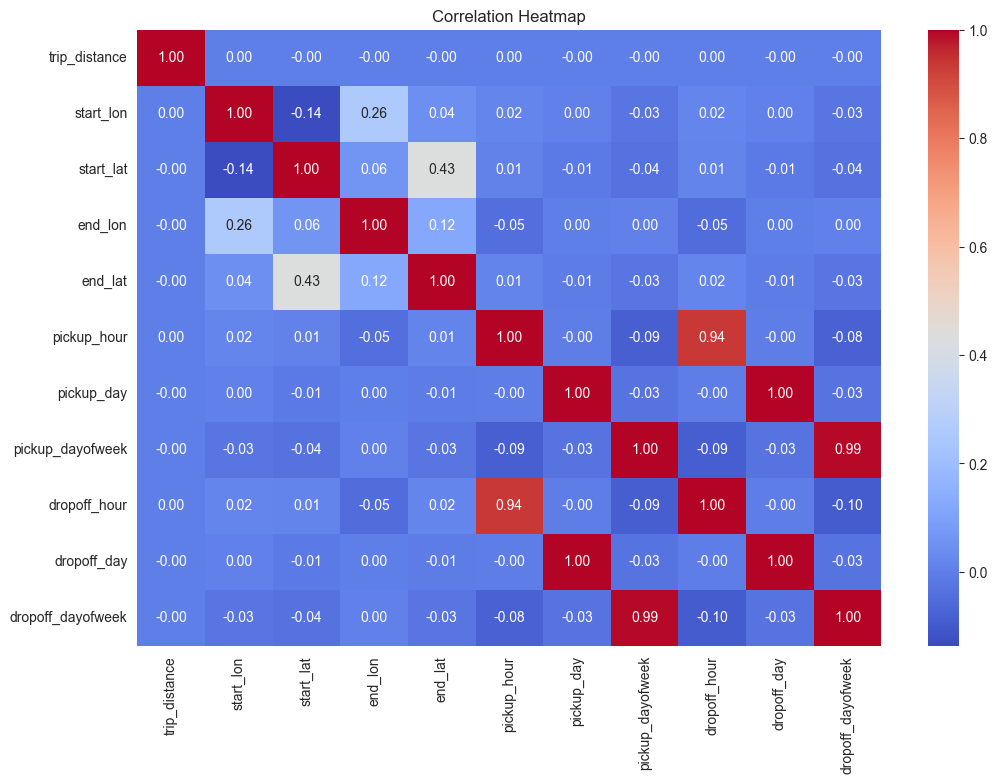

In [29]:
correlation = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [30]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,start_lon,start_lat,end_lon,end_lat,pickup_hour,pickup_day,pickup_dayofweek,dropoff_hour,dropoff_day,dropoff_dayofweek
0,2016-03-01,2016-03-01 00:07:55,2.50,-73.976746,40.765152,-74.004265,40.746128,0,1,1,0,1,1
1,2016-03-01,2016-03-01 00:11:06,2.90,-73.983482,40.767925,-74.005943,40.733166,0,1,1,0,1,1
2,2016-03-01,2016-03-01 00:31:06,19.98,-73.782021,40.644810,-73.974541,40.675770,0,1,1,0,1,1
3,2016-03-01,2016-03-01 00:00:00,10.78,-73.863419,40.769814,-73.969650,40.757767,0,1,1,0,1,1
4,2016-03-01,2016-03-01 00:00:00,30.43,-73.971741,40.792183,-74.177170,40.695053,0,1,1,0,1,1


## HDBSCAN

In [31]:
X = df[['start_lat', 'start_lon', 'end_lat', 'end_lon']]

In [32]:
X.describe().T[['min', 'max', 'mean', 'std']]

,min,max,mean,std
start_lat,40.493042,40.919994,40.750923,0.027739
start_lon,-74.259590,-73.700096,-73.973822,0.037554
end_lat,40.492943,40.919998,40.751686,0.031820
end_lon,-74.259796,-73.700005,-73.973672,0.034597


In [33]:
X.shape

(12001871, 4)

In [36]:
#test
df_sample = df.sample(min(200000, len(df)), random_state=42)

df_sample['delta_lat'] = df_sample['end_lat'] - df_sample['start_lat']
df_sample['delta_lon'] = df_sample['end_lon'] - df_sample['start_lon']

X = df_sample[['start_lat', 'start_lon', 'delta_lat', 'delta_lon']].to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clusterer = HDBSCAN(
    min_cluster_size=100,
    min_samples=15,
    metric='euclidean',
    n_jobs= -1,
    algorithm='auto')

labels = clusterer.fit_predict(X_scaled)

df_sample['cluster'] = labels
clusters_summary = df_sample[df_sample['cluster'] != -1].groupby('cluster').size().sort_values(ascending=False)
top_clusters = clusters_summary.head(20)
print(top_clusters)

cluster
18    160933
7       3772
3       2212
12      1793
5       1376
10       985
17       670
9        491
19       387
14       347
0        330
8        250
1        215
4        159
6        150
16       138
13       130
11       124
2        110
15       108
dtype: int64


In [40]:
top_clusters.to_csv(r"C:\Users\ASUS\Desktop\top_clusters.csv")
top_clusters = pd.read_csv("top_clusters.csv", index_col=0)
print(top_clusters)


              0
cluster        
18       160933
7          3772
3          2212
12         1793
5          1376
10          985
17          670
9           491
19          387
14          347
0           330
8           250
1           215
4           159
6           150
16          138
13          130
11          124
2           110
15          108


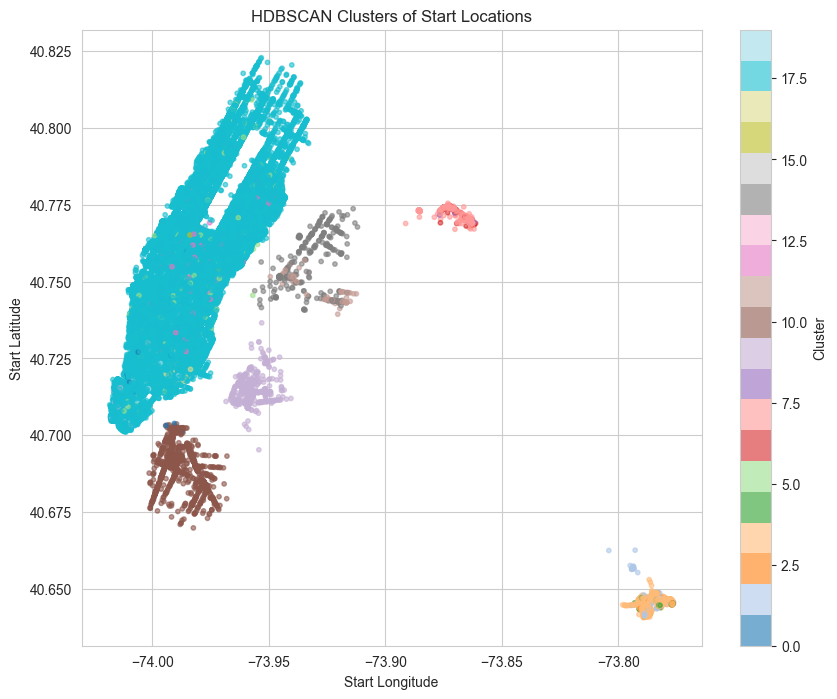

In [37]:
df_plot = df_sample[df_sample['cluster'] != -1]

plt.figure(figsize=(10,8))
scatter = plt.scatter(
    df_plot['start_lon'], df_plot['start_lat'],
    c=df_plot['cluster'], cmap='tab20', s=10, alpha=0.6
)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Start Longitude')
plt.ylabel('Start Latitude')
plt.title('HDBSCAN Clusters of Start Locations')
plt.show()

In [35]:
# X = df[['start_lat','start_lon','end_lat','end_lon']].to_numpy()
# X_rad = np.radians(X)
#
# clusterer = HDBSCAN(
#     min_cluster_size=100,
#     min_samples=15,
#     metric='euclidean',
#     algorithm='ball_tree',
#     n_jobs=-1)
#
# labels = clusterer.fit_predict(X_rad)
#
# df['cluster'] = labels
# clusters_summary = df[df['cluster'] != -1].groupby('cluster').size().sort_values(ascending=False)
# top_clusters = clusters_summary.head(20)
# print(top_clusters)

KeyboardInterrupt: 